# SuperReso

### Super Resolution without stupid ML

In [1]:
# Import Libraries
import cv2
import numpy as np
from scipy import ndimage
from PIL import Image 
import matplotlib.pyplot as plt

## Load and Visualize Images

In [2]:
# Load in blurry sample image as well as target image
target_image = cv2.imread('target_monkey.jpg')
sample_image = cv2.blur(cv2.imread('sample_monkey.jpg'), (15,15)) # For now, we will use the blurred raspberry image as our sample
# target_image = cv2.imread('target.jpg')
# sample_image = cv2.blur(cv2.imread('raspberries.png'), (15,15)) # For now, we will use the blurred raspberry image as our sample

In [3]:
target_image.shape

(640, 480, 3)

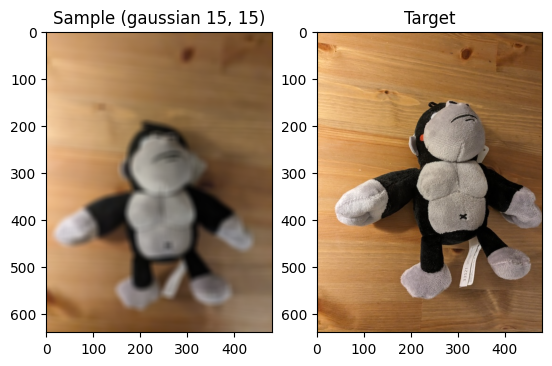

In [4]:
f, ax = plt.subplots(1,2)
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[0].title.set_text("Sample (gaussian 15, 15)")
ax[1].imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
ax[1].title.set_text("Target")

plt.show()

## Naively replace images by using the reference image

(640, 480, 3)
(640, 480, 3)


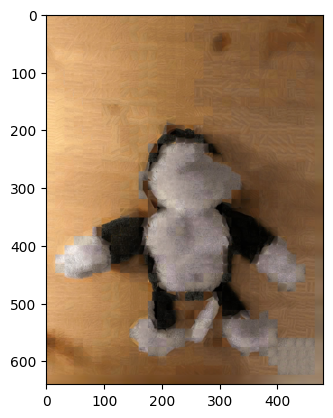

In [5]:
# Then parse through each PATCH_SIZE x PATCH_SIZE pixel patch
print(sample_image.shape)
width, height, _ = sample_image.shape
output_image = sample_image.copy()
candidates = []
for deg in range(0, 180, 30):
    candidates.append(ndimage.rotate(target_image, deg))

PATCH_SIZE = 16

for i in range(0, width-PATCH_SIZE, PATCH_SIZE):
    for j in range(0, height-PATCH_SIZE, PATCH_SIZE):
        patch = sample_image[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
#         plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
#         plt.show()
        # For each patch, look for nearest match with the target image
        best_val = float('inf')
        for candidate in candidates:
            res = cv2.matchTemplate(candidate, patch, cv2.TM_SQDIFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            if min_val < best_val:
                best_val = min_val
                best_patch = candidate[min_loc[1]:min_loc[1]+PATCH_SIZE, min_loc[0]:min_loc[0]+PATCH_SIZE, :]
#         plt.imshow(cv2.cvtColor(best_patch, cv2.COLOR_BGR2RGB), cmap = 'gray')
#         plt.show()

        # Then replace that patch with the nearest match
        output_image[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :] = best_patch
#         break
#     break

# Display output image
print(output_image.shape)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

## Use Cuts from Efros PhD

In [6]:
def cut(new_patch, old_patch, overlap):
    seam_mask = np.zeros(new_patch.shape)
    # Difference and abs is the same as squared difference
    cost = np.sum(np.abs(new_patch-old_patch), axis=2)
    j = np.argmin(cost[0][:overlap])
    points = []
    # Update seam mask
    seam_mask[0, j:] = 1
    points.append(j)
    for i in range(1, new_patch.shape[0]):
        j = max(0, j-1) + np.argmin(cost[i][max(0, j-1):min(j+2, overlap)])
        seam_mask[i, j:] = 1
        points.append(j)
    return seam_mask, points

(640, 480, 3)
(640, 480, 3)


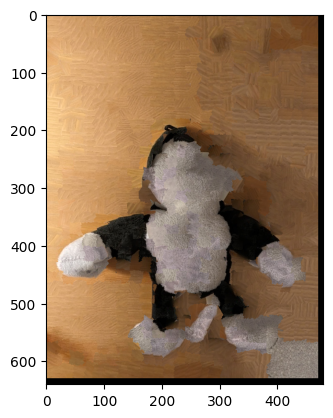

In [7]:
# Then parse through each 32 x 32 pixel patch
print(sample_image.shape)
width, height, _ = sample_image.shape
output_image = np.zeros(sample_image.shape, dtype=np.uint8)
targets = []
for deg in range(0, 180, 30):
    targets.append(ndimage.rotate(target_image, deg))

PATCH_SIZE = 30
OVERLAP = 10
CHUNK_SIZE = PATCH_SIZE - OVERLAP

for i in range(0, (width // CHUNK_SIZE) - 1):
    for j in range(0, (height // CHUNK_SIZE) - 1):
        curr_indices = (slice(i*CHUNK_SIZE,i*CHUNK_SIZE+PATCH_SIZE), slice(j*CHUNK_SIZE,j*CHUNK_SIZE+PATCH_SIZE))
        patch = sample_image[curr_indices]
#         print("Currently editing slice:", curr_indices)
#         plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
#         plt.show()
        
        # TODO: Could be worth it to find the best candidateS to consider rather than just ONE 
        # For each patch, look for nearest match with the target image
        best_val = float('inf')
        for target in targets:
            res = cv2.matchTemplate(target, patch, cv2.TM_SQDIFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            # TODO: Consider threshing the value?
            if min_val < best_val:
                best_val = min_val
                best_patch = target[min_loc[1]:min_loc[1]+PATCH_SIZE, min_loc[0]:min_loc[0]+PATCH_SIZE, :]
#         plt.imshow(cv2.cvtColor(best_patch, cv2.COLOR_BGR2RGB))
#         plt.show()
        if i == 0 and j == 0:
            output_image[curr_indices] = best_patch
#             plt.imshow(cv2.cvtColor(best_patch, cv2.COLOR_BGR2RGB))
#             plt.title(f"i:{i},j:{j}")
            plt.show()
        else:
            # Compute overlap
            if j != 0:
                seam_mask_vert, points_vert = cut(best_patch, output_image[curr_indices], OVERLAP)
            else:
                seam_mask_vert = np.ones(best_patch.shape)
            if i != 0:
                seam_mask_hori, points_hori = cut(best_patch.transpose(1, 0, 2), output_image[curr_indices].transpose(1, 0, 2), OVERLAP)
                seam_mask_hori = seam_mask_hori.transpose(1, 0, 2)
            else:
                seam_mask_hori = np.ones(best_patch.shape)
            seam_mask = np.logical_and(seam_mask_vert, seam_mask_hori).astype(float)
            combined_patch = np.where(seam_mask==1, best_patch, output_image[curr_indices])
    #         plt.imshow(seam_mask)
    #         plt.show()

            # Then replace that patch with the nearest match using mask
            combined_patch = np.where(seam_mask==1, best_patch, output_image[curr_indices])
#             plt.imshow(cv2.cvtColor(combined_patch, cv2.COLOR_BGR2RGB))
#             plt.title(f"i:{i},j:{j}")
#             plt.show()
            output_image[curr_indices] = combined_patch
        
#         if j == 5:
#             break
#     if i == 5:
#         break


# Display output image
print(output_image.shape)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [8]:
# Then parse through each 32 x 32 pixel patch
print(sample_image.shape)
width, height, _ = sample_image.shape
output_image = np.zeros(sample_image.shape, dtype=np.uint8)
targets = []
for i, deg in enumerate(range(0, 360, 30)):
    targets.append(ndimage.rotate(target_image, deg))
    oldwidth, oldheight, _ = target_image.shape
    newshape = (oldwidth//(2**i), oldheight//(2**i))
    print("New shape:", newshape)
#     plt.imshow(cv2.resize(target_image, newshape, interpolation = cv2.INTER_LINEAR))
#     plt.show()
    targets.append(ndimage.rotate(cv2.resize(target_image, newshape, interpolation = cv2.INTER_LINEAR), deg))

PATCH_SIZE = 30
OVERLAP = 10
CHUNK_SIZE = PATCH_SIZE - OVERLAP

for i in range(0, (width // CHUNK_SIZE) - 1):
    for j in range(0, (height // CHUNK_SIZE) - 1):
        print(i, j)
        curr_indices = (slice(i*CHUNK_SIZE,i*CHUNK_SIZE+PATCH_SIZE), slice(j*CHUNK_SIZE,j*CHUNK_SIZE+PATCH_SIZE))
        patch = sample_image[curr_indices]
#         print("Currently editing slice:", curr_indices)
#         plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
#         plt.show()
        
        # TODO: Could be worth it to find the best candidateS to consider rather than just ONE 
        # For each patch, look for nearest match with the target image
        best_val = float('inf')
        for target in targets:
            res = cv2.matchTemplate(target, patch, cv2.TM_SQDIFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            # TODO: Consider threshing the value?
            if min_val < best_val:
                best_val = min_val
                best_patch = target[min_loc[1]:min_loc[1]+PATCH_SIZE, min_loc[0]:min_loc[0]+PATCH_SIZE, :]
        print("Best Val:", best_val)
        if best_val > 0.1:
            best_patch = patch
#         plt.imshow(cv2.cvtColor(best_patch, cv2.COLOR_BGR2RGB))
#         plt.show()
        if i == 0 and j == 0:
            output_image[curr_indices] = best_patch
#             plt.imshow(cv2.cvtColor(best_patch, cv2.COLOR_BGR2RGB))
#             plt.title(f"i:{i},j:{j}")
            plt.show()
        else:
            # Compute overlap
            if j != 0:
                seam_mask_vert, points_vert = cut(best_patch, output_image[curr_indices], OVERLAP)
            else:
                seam_mask_vert = np.ones(best_patch.shape)
                
            if i != 0:
                seam_mask_hori, points_hori = cut(best_patch.transpose(1, 0, 2), output_image[curr_indices].transpose(1, 0, 2), OVERLAP)
                seam_mask_hori = seam_mask_hori.transpose(1, 0, 2)
            else:
                seam_mask_hori = np.ones(best_patch.shape)
                
            seam_mask = np.logical_and(seam_mask_vert, seam_mask_hori).astype(float)
            combined_patch = np.where(seam_mask==1, best_patch, output_image[curr_indices])
    #         plt.imshow(seam_mask)
    #         plt.show()

            # Then replace that patch with the nearest match using mask
            combined_patch = np.where(seam_mask==1, best_patch, output_image[curr_indices])
#             plt.imshow(cv2.cvtColor(combined_patch, cv2.COLOR_BGR2RGB))
#             plt.title(f"i:{i},j:{j}")
#             plt.show()
            output_image[curr_indices] = combined_patch
        
#         if j == 5:
#             break
#     if i == 5:
#         break


# Display output image
print(output_image.shape)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

(640, 480, 3)
New shape: (640, 480)
New shape: (320, 240)
New shape: (160, 120)
New shape: (80, 60)
New shape: (40, 30)
New shape: (20, 15)
New shape: (10, 7)
New shape: (5, 3)
New shape: (2, 1)
New shape: (1, 0)


error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4055: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'
